In [28]:
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
import scipy.stats as st

from plot.scatter import scatter_plot, _set_axis_config
from plot.summary import summary_plot
from plot.colors import green_gold

In [2]:
dataset = tfds.load(name='higgs', split='train')
feature_names = list(dataset.output_shapes.keys())[1:]

In [3]:
attributions  = np.load('attributions.npy')
interactions  = np.load('interactions.npy')
input_samples = np.load('input_samples.npy')
pred_output   = np.load('pred_output.npy')
true_labels   = np.load('true_labels.npy')

In [14]:
m_wbb = input_samples[:, feature_names.index('m_wbb')]
m_wwbb = input_samples[:, feature_names.index('m_wwbb')]

In [15]:
feature_names.index('m_wbb')

24

In [16]:
feature_names.index('m_wwbb')

25

In [17]:
pearsonr(m_wbb, m_wwbb)

(0.8990349664316752, 0.0)

In [18]:
linear_model = LinearRegression()
linear_model.fit(m_wbb.reshape(-1, 1), m_wwbb)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [19]:
m_wwbb_pred = linear_model.predict(m_wbb.reshape(-1, 1))
residuals = m_wwbb - m_wwbb_pred
squared_residuals = np.square(residuals)
mse = np.mean(squared_residuals)
r_squared = linear_model.score(m_wbb.reshape(-1, 1), m_wwbb)
print('R^2: {:.4f}, MSE: {:.4f}'.format(r_squared, mse))

R^2: 0.8083, MSE: 1.9928


In [20]:
model_x = np.linspace(np.min(m_wbb), np.max(m_wbb), num=100)
model_y = linear_model.predict(model_x.reshape(-1, 1))

In [21]:
def customize_axis(ax, xlabel, ylabel, title, ax_below=True):
    _set_axis_config(ax, [0.2, 0.2, 1.0, 1.0])
    ax.grid(linewidth=0.5)
    ax.set_axisbelow(ax_below)
    ax.tick_params(length=6, labelsize=12)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_title(title, fontsize=18)

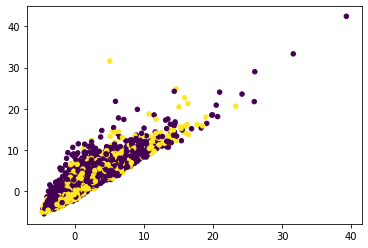

In [40]:
plt.scatter(x=m_wbb,
            y=m_wwbb,
            c=true_labels,
            s=20)

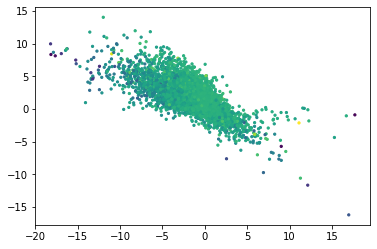

In [42]:
plt.scatter(x=attributions[:, feature_names.index('m_wbb')],
            y=attributions[:, feature_names.index('m_wwbb')],
            c=interactions[:, feature_names.index('m_wbb'), feature_names.index('m_wwbb')],
            s=5)

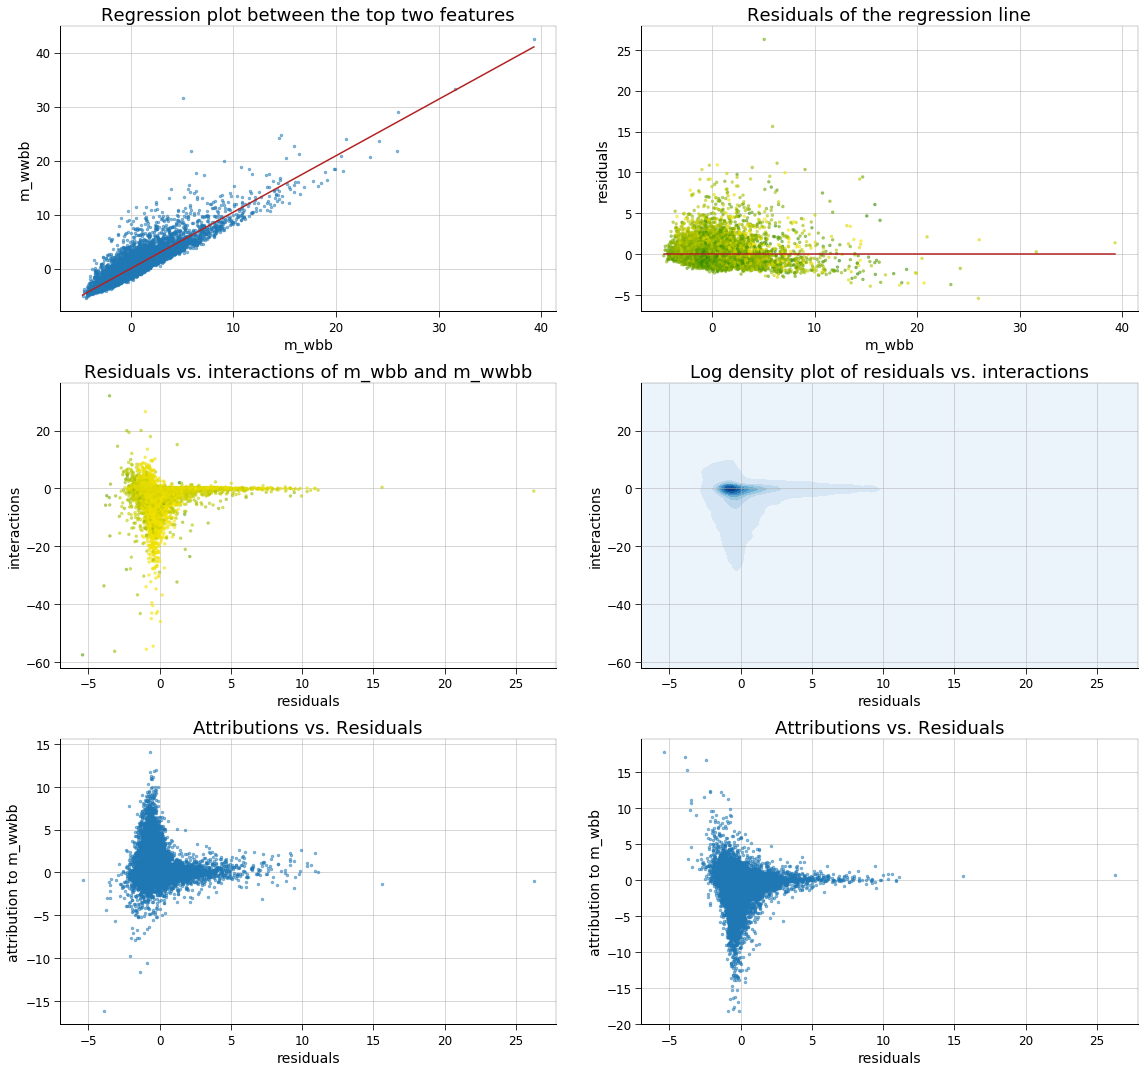

In [46]:
fig, axs = plt.subplots(3, 2, figsize=(16, 15))
ax = axs[0, 0]
ax.scatter(x=m_wbb,
           y=m_wwbb,
           s=6,
           alpha=0.5)
ax.plot(model_x,
        model_y,
        c='firebrick')
customize_axis(ax, 'm_wbb', 'm_wwbb', 'Regression plot between the top two features')

ax = axs[0, 1]
ax.scatter(x=m_wbb,
           y=residuals,
           s=6,
           alpha=0.5,
           c=pred_output,
           cmap=green_gold())
ax.plot(model_x,
        np.zeros(model_x.shape),
        c='firebrick')
customize_axis(ax, 'm_wbb', 'residuals', 'Residuals of the regression line')

ax = axs[1, 0]
ax.scatter(x=residuals,
           y=interactions[:, feature_names.index('m_wbb'), feature_names.index('m_wwbb')],
           s=6,
           alpha=0.5,
           c=input_samples[:, feature_names.index('m_wbb')],
           cmap=green_gold())
customize_axis(ax, 'residuals', 'interactions', 'Residuals vs. interactions of m_wbb and m_wwbb')
xlim = ax.get_xlim()
ylim = ax.get_ylim()

ax = axs[1, 1]
x = residuals
y = interactions[:, feature_names.index('m_wbb'), feature_names.index('m_wwbb')]
xx, yy = np.mgrid[xlim[0]:xlim[1]:100j, ylim[0]:ylim[1]:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)
cfset = ax.contourf(xx, yy, np.log(f + 0.1), cmap='Blues')
customize_axis(ax, 'residuals', 'interactions', 'Log density plot of residuals vs. interactions', False)


ax = axs[2, 0]
ax.scatter(x=residuals,
           y=attributions[:, feature_names.index('m_wwbb')],
           s=6,
           alpha=0.5)
customize_axis(ax, 'residuals', 'attribution to m_wwbb', 'Attributions vs. Residuals')

ax = axs[2, 1]
ax.scatter(x=residuals,
           y=attributions[:, feature_names.index('m_wbb')],
           s=6,
           alpha=0.5)
customize_axis(ax, 'residuals', 'attribution to m_wbb', 'Attributions vs. Residuals')

plt.tight_layout()

### Normal evaluation:
```
Evaluating model with flip indices set to False
---------- Train Set ----------
100000/100000 - 1351s - loss: 0.4814 - binary_accuracy: 0.7710 - auc: 0.8622
---------- Vald Set ----------
5000/5000 - 114s - loss: 0.4827 - binary_accuracy: 0.7706 - auc: 0.8615
```

### Flipped Evaluation:
```
Evaluating model with flip indices set to True
---------- Train Set ----------
100000/100000 - 1355s - loss: 0.5531 - binary_accuracy: 0.7221 - auc: 0.8044
---------- Vald Set ----------
5000/5000 - 113s - loss: 0.5535 - binary_accuracy: 0.7218 - auc: 0.8042
```

Hmmm... definitely didn't observe the pattern I was hoping for. Still interesting though!